<a href="https://colab.research.google.com/github/TerMinator-spec/Food_classification/blob/master/Copy_of_food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [ ]:
!kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [01:52<00:00, 55.1MB/s]
100% 5.30G/5.30G [01:57<00:00, 48.4MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import skimage
import matplotlib.pyplot as plt
import sys

In [ ]:
f=h5py.File('./food_c101_n1000_r384x384x3.h5','r')

In [ ]:
print(list(f.keys()))
print(len(f["category"]))
print(len(f["category_names"]))
print(len(f["images"]))

['category', 'category_names', 'images']
1000
101
1000


In [ ]:
f=h5py.File('./food_c101_n10099_r64x64x3.h5','r')
print(list(f.keys()))
print(len(f["category"]))
print(len(f["category_names"]))
print(len(f["images"]))

['category', 'category_names', 'images']
10099
101
10099


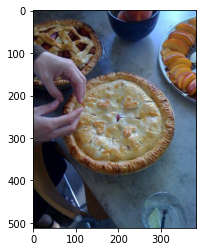

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('./images/apple_pie/134.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
plt.imshow(img)

In [ ]:
import os
subdirs = [x[0] for x in os.walk('.')]
print(subdirs)
classes=[]
for i in range(1,len(subdirs)):
  classes.append(subdirs[i][8:])

In [ ]:
import os
import numpy as np
import shutil
import random

# # Creating Train / Val / Test folders (One time use)
root_dir = ".\images"
classes_dir = classes

val_ratio = 0.15
test_ratio = 0.05

for cls in classes_dir:
    os.makedirs(root_dir +'/train' + cls)
    os.makedirs(root_dir +'/val' + cls)
    os.makedirs(root_dir +'/test' + cls)


    # Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio + test_ratio)), 
                                                               int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test' + cls)

In [ ]:
import os
subdirs = [x[0] for x in os.walk('./data/train')]
print(subdirs)
classes=[]
for i in range(1,len(subdirs)):
  classes.append(subdirs[i][13:])

len(classes)


['./data/train', './data/train/apple_pie', './data/train/baby_back_ribs', './data/train/baklava', './data/train/beef_carpaccio', './data/train/beef_tartare', './data/train/beet_salad', './data/train/beignets', './data/train/bibimbap', './data/train/bread_pudding', './data/train/breakfast_burrito', './data/train/bruschetta', './data/train/caesar_salad', './data/train/cannoli', './data/train/caprese_salad', './data/train/carrot_cake', './data/train/ceviche', './data/train/cheese_plate', './data/train/cheesecake', './data/train/chicken_curry', './data/train/chicken_quesadilla', './data/train/chicken_wings', './data/train/chocolate_cake', './data/train/chocolate_mousse', './data/train/churros', './data/train/clam_chowder', './data/train/club_sandwich', './data/train/crab_cakes', './data/train/creme_brulee', './data/train/croque_madame', './data/train/cup_cakes', './data/train/deviled_eggs', './data/train/donuts']


32

In [ ]:
N_CLASSES=len(classes)
IMG_SIZE=250
import keras
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [ ]:
model = inception()
model.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 124, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.Adam(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [ ]:
zip_path = "./data.zip"
!cp "{zip_path}" .
!unzip -q data.zip
!rm data.zip

cp: './data.zip' and './data.zip' are the same file
replace data/train/apple_pie/323108.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/train/apple_pie/1323309.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('./data/train',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('./data/val',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 28800 images belonging to 32 classes.
Found 1600 images belonging to 32 classes.


In [ ]:
STEP_SIZE_TRAIN=training_set.n//32
STEP_SIZE_VALID=test_set.n//32

In [ ]:
model.fit_generator(training_set,
                         steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_set,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
900/900 [==============================] - 558s 620ms/step - loss: 1.3218 - accuracy: 0.6351 - val_loss: 0.8556 - val_accuracy: 0.7513
Epoch 2/10
900/900 [==============================] - 567s 630ms/step - loss: 0.8013 - accuracy: 0.7662 - val_loss: 0.8406 - val_accuracy: 0.7575
Epoch 3/10
900/900 [==============================] - 563s 626ms/step - loss: 0.6691 - accuracy: 0.8005 - val_loss: 0.7524 - val_accuracy: 0.7931
Epoch 4/10
900/900 [==============================] - 563s 625ms/step - loss: 0.5637 - accuracy: 0.8282 - val_loss: 0.7672 - val_accuracy: 0.7831
Epoch 5/10
900/900 [==============================] - 549s 610ms/step - loss: 0.4954 - accuracy: 0.8492 - val_loss: 0.8054 - val_accuracy: 0.7763
Epoch 6/10
900/900 [==============================] - 545s 606ms/step - loss: 0.4262 - accuracy: 0.8639 - val_loss: 0.8141 - val_accuracy: 0.7819
Epoch 7/10
900/900 [============================

In [ ]:

model.save("./model.h5")